In [4]:
####################### BLOCK 1: IMPORTS AND UTILITIES #######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def prepare_data(data, selected_features):
    """
    Prepare data for clustering
    
    # Parameters
    data: pandas DataFrame or numpy array
    selected_features: list 
        If DataFrame: column names or indices
        If array: column indices
    """
    if isinstance(data, pd.DataFrame):
        if isinstance(selected_features[0], str):
            X = data[selected_features].values
            feature_names = selected_features
        else:
            X = data.iloc[:, selected_features].values
            feature_names = data.columns[selected_features].tolist()
    else:
        X = data[:, selected_features]
        feature_names = [f"Feature {i}" for i in selected_features]
    
    return X, feature_names

def plot_clusters(X, labels, feature_names, title="Clustering Results", ax=None):
    """Utility function to plot clustering results"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], label=f'Cluster {label}')
    
    ax.set_title(title)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.legend()
    return ax

In [5]:
####################### BLOCK 2: K-MEANS #######################
def kmeans_clustering(data, selected_features, n_clusters=3):
    """
    Perform K-Means clustering
    
    # Note: Can determine optimal n_clusters using:
    # - Elbow method
    # - Silhouette analysis
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Plot results
    plot_clusters(X, labels, feature_names, "K-Means Clustering")
    plt.show()
    
    return kmeans, labels

In [6]:
####################### BLOCK 3: DBSCAN #######################
def dbscan_clustering(data, selected_features, eps=0.5, min_samples=5):
    """
    Perform DBSCAN clustering
    
    # Note: Number of clusters is determined automatically
    # Can estimate eps using nearest neighbors plot
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # Plot results
    plot_clusters(X, labels, feature_names, "DBSCAN Clustering")
    plt.show()
    
    return dbscan, labels

In [7]:
####################### BLOCK 4: MEAN SHIFT #######################
def meanshift_clustering(data, selected_features):
    """
    Perform Mean-Shift clustering
    
    # Note: Number of clusters is determined automatically
    # based on the data density
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Mean-Shift
    ms = MeanShift(bandwidth=2)
    labels = ms.fit_predict(X_scaled)
    
    # Plot results
    plot_clusters(X, labels, feature_names, "Mean-Shift Clustering")
    plt.show()
    
    return ms, labels

In [8]:
def gmm_clustering(data, selected_features, n_components=3):
    """
    Perform Gaussian Mixture clustering
    
    # Note: Can determine optimal n_components using:
    # - BIC (Bayesian Information Criterion)
    # - AIC (Akaike Information Criterion)
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    
    # Plot results
    plot_clusters(X, labels, feature_names, "Gaussian Mixture Clustering")
    plt.show()
    
    return gmm, labels

In [9]:

####################### BLOCK 6: HIERARCHICAL #######################
def hierarchical_clustering(data, selected_features, n_clusters=3):
    """
    Perform Hierarchical clustering
    
    # Note: Can determine optimal n_clusters using:
    # - Dendrogram analysis
    # - Silhouette analysis
    """
    # Prepare data
    X, feature_names = prepare_data(data, selected_features)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit Hierarchical Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hc.fit_predict(X_scaled)
    
    # Plot results
    plot_clusters(X, labels, feature_names, "Hierarchical Clustering")
    plt.show()
    
    return hc, labels

In [10]:
data = [{"ID": "J0847+0112", "Mg_Fe": 0.3, "t_bur": 12.0, "t_max": 11.6, "delta_t": 0.2, "MH_bur": 0.30, "MH_max": 0.35, "delta_MH": 0.02, "f_M_sfm": 0.9988, "f_M_sfm_err": 0.0002, "t75": 0.9, "t75_err": 0.3, "t_fin": 2.0, "t_fin_err": 0.7, "t_Univ_z": 11.52, "DoR": 0.83},
   {"ID": "J2305-3436", "Mg_Fe": 0.3, "t_bur": 10.5, "t_max": 10.1, "delta_t": 0.2, "MH_bur": 0.32, "MH_max": 0.34, "delta_MH": 0.02, "f_M_sfm": 0.9980, "f_M_sfm_err": 0.0007, "t75": 1.0, "t75_err": 0.3, "t_fin": 2.0, "t_fin_err": 0.7, "t_Univ_z": 10.29, "DoR": 0.80},
   {"ID": "J0920+0147", "Mg_Fe": 0.4, "t_bur": 11.4, "t_max": 11.1, "delta_t": 0.2, "MH_bur": 0.27, "MH_max": 0.31, "delta_MH": 0.02, "f_M_sfm": 0.9950, "f_M_sfm_err": 0.0013, "t75": 0.9, "t75_err": 0.2, "t_fin": 3.0, "t_fin_err": 4.0, "t_Univ_z": 11.11, "DoR": 0.79},
   {"ID": "J2204-3112", "Mg_Fe": 0.3, "t_bur": 11.0, "t_max": 10.6, "delta_t": 0.3, "MH_bur": 0.27, "MH_max": 0.30, "delta_MH": 0.02, "f_M_sfm": 0.9992, "f_M_sfm_err": 0.0003, "t75": 1.0, "t75_err": 0.4, "t_fin": 2.5, "t_fin_err": 0.9, "t_Univ_z": 10.67, "DoR": 0.78},
   {"ID": "J1438-0127", "Mg_Fe": 0.4, "t_bur": 10.5, "t_max": 9.9, "delta_t": 0.4, "MH_bur": 0.05, "MH_max": 0.11, "delta_MH": 0.05, "f_M_sfm": 0.9971, "f_M_sfm_err": 0.0003, "t75": 0.9, "t75_err": 0.3, "t_fin": 3.0, "t_fin_err": 1.1, "t_Univ_z": 10.40, "DoR": 0.78},
   {"ID": "J1040+0056", "Mg_Fe": 0.4, "t_bur": 10.9, "t_max": 10.6, "delta_t": 0.2, "MH_bur": 0.27, "MH_max": 0.28, "delta_MH": 0.02, "f_M_sfm": 0.991, "f_M_sfm_err": 0.003, "t75": 1.0, "t75_err": 0.3, "t_fin": 3.0, "t_fin_err": 3.9, "t_Univ_z": 10.54, "DoR": 0.77},
   {"ID": "J0842+0059", "Mg_Fe": 0.4, "t_bur": 10.5, "t_max": 10.0, "delta_t": 0.2, "MH_bur": 0.22, "MH_max": 0.26, "delta_MH": 0.02, "f_M_sfm": 0.983, "f_M_sfm_err": 0.007, "t75": 1.1, "t75_err": 0.3, "t_fin": 3.5, "t_fin_err": 1.8, "t_Univ_z": 10.31, "DoR": 0.73},
   {"ID": "J0211-3155", "Mg_Fe": 0.3, "t_bur": 10.4, "t_max": 9.9, "delta_t": 0.2, "MH_bur": 0.26, "MH_max": 0.28, "delta_MH": 0.03, "f_M_sfm": 0.989, "f_M_sfm_err": 0.003, "t75": 1.1, "t75_err": 0.3, "t_fin": 3.5, "t_fin_err": 4.0, "t_Univ_z": 10.26, "DoR": 0.72},
   {"ID": "J2359-3320", "Mg_Fe": 0.2, "t_bur": 10.4, "t_max": 9.7, "delta_t": 0.2, "MH_bur": 0.34, "MH_max": 0.33, "delta_MH": 0.03, "f_M_sfm": 0.993, "f_M_sfm_err": 0.002, "t75": 1.4, "t75_err": 0.4, "t_fin": 3.0, "t_fin_err": 3.9, "t_Univ_z": 10.38, "DoR": 0.71},
   {"ID": "J0920+0212", "Mg_Fe": 0.3, "t_bur": 10.4, "t_max": 9.9, "delta_t": 0.3, "MH_bur": 0.23, "MH_max": 0.26, "delta_MH": 0.03, "f_M_sfm": 0.968, "f_M_sfm_err": 0.012, "t75": 0.9, "t75_err": 0.2, "t_fin": 7.0, "t_fin_err": 3.8, "t_Univ_z": 10.46, "DoR": 0.64},
   {"ID": "J1412-0020", "Mg_Fe": 0.0, "t_bur": 10.3, "t_max": 9.3, "delta_t": 0.3, "MH_bur": 0.40, "MH_max": 0.32, "delta_MH": 0.03, "f_M_sfm": 0.93, "f_M_sfm_err": 0.03, "t75": 1.9, "t75_err": 0.6, "t_fin": 4.5, "t_fin_err": 4.1, "t_Univ_z": 10.48, "DoR": 0.61},
   {"ID": "J1449-0138", "Mg_Fe": 0.3, "t_bur": 10.9, "t_max": 10.2, "delta_t": 0.3, "MH_bur": 0.21, "MH_max": 0.25, "delta_MH": 0.03, "f_M_sfm": 0.961, "f_M_sfm_err": 0.019, "t75": 1.5, "t75_err": 0.3, "t_fin": 6.5, "t_fin_err": 3.8, "t_Univ_z": 10.60, "DoR": 0.60},
   {"ID": "J0224-3143", "Mg_Fe": 0.3, "t_bur": 9.8, "t_max": 9.4, "delta_t": 0.3, "MH_bur": 0.18, "MH_max": 0.21, "delta_MH": 0.03, "f_M_sfm": 0.976, "f_M_sfm_err": 0.004, "t75": 0.9, "t75_err": 0.2, "t_fin": 9.0, "t_fin_err": 3.7, "t_Univ_z": 9.53, "DoR": 0.56},
   {"ID": "J0838+0052", "Mg_Fe": 0.3, "t_bur": 10.5, "t_max": 9.8, "delta_t": 0.5, "MH_bur": 0.11, "MH_max": 0.13, "delta_MH": 0.04, "f_M_sfm": 0.85, "f_M_sfm_err": 0.05, "t75": 1.9, "t75_err": 0.6, "t_fin": 6.0, "t_fin_err": 3.3, "t_Univ_z": 10.56, "DoR": 0.54},
   {"ID": "J0217-2957", "Mg_Fe": 0.4, "t_bur": 10.6, "t_max": 10.3, "delta_t": 0.3, "MH_bur": 0.17, "MH_max": 0.19, "delta_MH": 0.04, "f_M_sfm": 0.949, "f_M_sfm_err": 0.013, "t75": 1.1, "t75_err": 0.3, "t_fin": 10.0, "t_fin_err": 4.0, "t_Univ_z": 10.64, "DoR": 0.51},
   {"ID": "J2202-3101", "Mg_Fe": 0.2, "t_bur": 10.4, "t_max": 9.5, "delta_t": 0.5, "MH_bur": 0.18, "MH_max": 0.22, "delta_MH": 0.03, "f_M_sfm": 0.82, "f_M_sfm_err": 0.07, "t75": 1.5, "t75_err": 0.4, "t_fin": 8.0, "t_fin_err": 2.9, "t_Univ_z": 10.10, "DoR": 0.48},
   {"ID": "J1457-0140", "Mg_Fe": 0.2, "t_bur": 9.2, "t_max": 8.5, "delta_t": 0.5, "MH_bur": 0.11, "MH_max": 0.12, "delta_MH": 0.05, "f_M_sfm": 0.81, "f_M_sfm_err": 0.07, "t75": 2.1, "t75_err": 0.7, "t_fin": 7.0, "t_fin_err": 2.7, "t_Univ_z": 9.93, "DoR": 0.47},
   {"ID": "J0844+0148", "Mg_Fe": 0.4, "t_bur": 9.8, "t_max": 9.1, "delta_t": 0.1, "MH_bur": 0.12, "MH_max": 0.17, "delta_MH": 0.05, "f_M_sfm": 0.91, "f_M_sfm_err": 0.02, "t75": 1.5, "t75_err": 0.4, "t_fin": 10.0, "t_fin_err": 4.0, "t_Univ_z": 10.43, "DoR": 0.45},
   {"ID": "J1218+0232", "Mg_Fe": 0.3, "t_bur": 10.2, "t_max": 9.3, "delta_t": 0.4, "MH_bur": 0.06, "MH_max": 0.14, "delta_MH": 0.05, "f_M_sfm": 0.89, "f_M_sfm_err": 0.04, "t75": 1.5, "t75_err": 0.5, "t_fin": 9.5, "t_fin_err": 3.3, "t_Univ_z": 10.20, "DoR": 0.45},
   {"ID": "J2356-3332", "Mg_Fe": 0.2, "t_bur": 8.9, "t_max": 7.9, "delta_t": 0.7, "MH_bur": 0.25, "MH_max": 0.29, "delta_MH": 0.05, "f_M_sfm": 0.90, "f_M_sfm_err": 0.02, "t75": 1.7, "t75_err": 0.6, "t_fin": 9.5, "t_fin_err": 3.9, "t_Univ_z": 9.92, "DoR": 0.44},
   {"ID": "J0917-0123", "Mg_Fe": 0.4, "t_bur": 9.6, "t_max": 8.4, "delta_t": 0.3, "MH_bur": 0.10, "MH_max": 0.18, "delta_MH": 0.04, "f_M_sfm": 0.89, "f_M_sfm_err": 0.03, "t75": 1.6, "t75_err": 0.5, "t_fin": 9.5, "t_fin_err": 3.9, "t_Univ_z": 9.73, "DoR": 0.44},
   {"ID": "J0918+0122", "Mg_Fe": 0.2, "t_bur": 9.3, "t_max": 8.6, "delta_t": 0.3, "MH_bur": 0.20, "MH_max": 0.23, "delta_MH": 0.05, "f_M_sfm": 0.90, "f_M_sfm_err": 0.03, "t75": 1.6, "t75_err": 0.5, "t_fin": 9.5, "t_fin_err": 4.0, "t_Univ_z": 9.62, "DoR": 0.43}
        ]

import pandas as pd
df = pd.DataFrame(data)

In [11]:
####################### BLOCK 7: EXAMPLE USAGE #######################

# Print available features
print("Available features:", df.columns.tolist())

# Select features you want to use
selected_features = ['t_bur', 'MH_bur', 'Mg_Fe']  # or [0, 1, 2] for indices

"""
# Try different clustering methods
kmeans_model, kmeans_labels = kmeans_clustering(df, selected_features, n_clusters=3)

dbscan_model, dbscan_labels = dbscan_clustering(df, selected_features, eps=0.5, min_samples=5)

hc_model, hc_labels = hierarchical_clustering(df, selected_features, n_clusters=3)

"""

Available features: ['ID', 'Mg_Fe', 't_bur', 't_max', 'delta_t', 'MH_bur', 'MH_max', 'delta_MH', 'f_M_sfm', 'f_M_sfm_err', 't75', 't75_err', 't_fin', 't_fin_err', 't_Univ_z', 'DoR']


'\n# Try different clustering methods\nkmeans_model, kmeans_labels = kmeans_clustering(df, selected_features, n_clusters=3)\n\ndbscan_model, dbscan_labels = dbscan_clustering(df, selected_features, eps=0.5, min_samples=5)\n\nhc_model, hc_labels = hierarchical_clustering(df, selected_features, n_clusters=3)\n\n'

Available features: ['ID', 'Mg_Fe', 't_bur', 't_max', 'delta_t', 'MH_bur', 'MH_max', 'delta_MH', 'f_M_sfm', 'f_M_sfm_err', 't75', 't75_err', 't_fin', 't_fin_err', 't_Univ_z', 'DoR']

=== K-Means Clustering ===


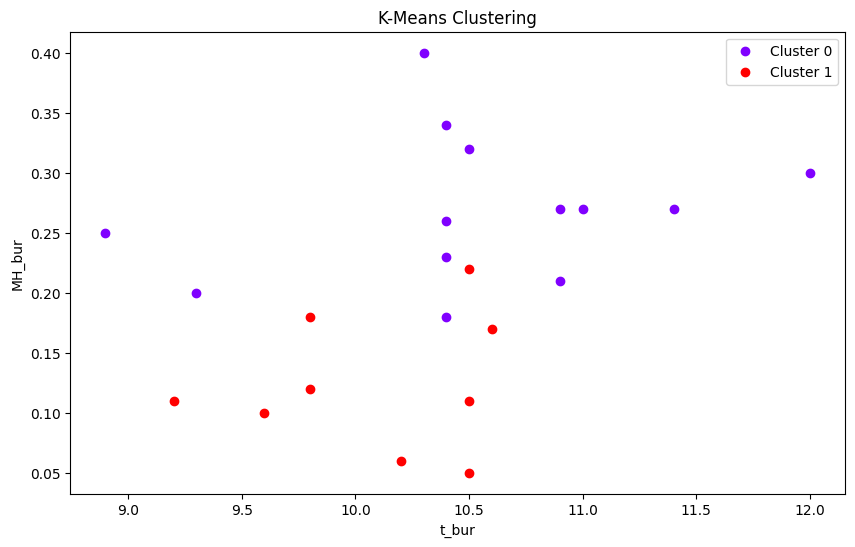

K-Means with 2 clusters:
{np.int32(0): np.int64(13), np.int32(1): np.int64(9)}


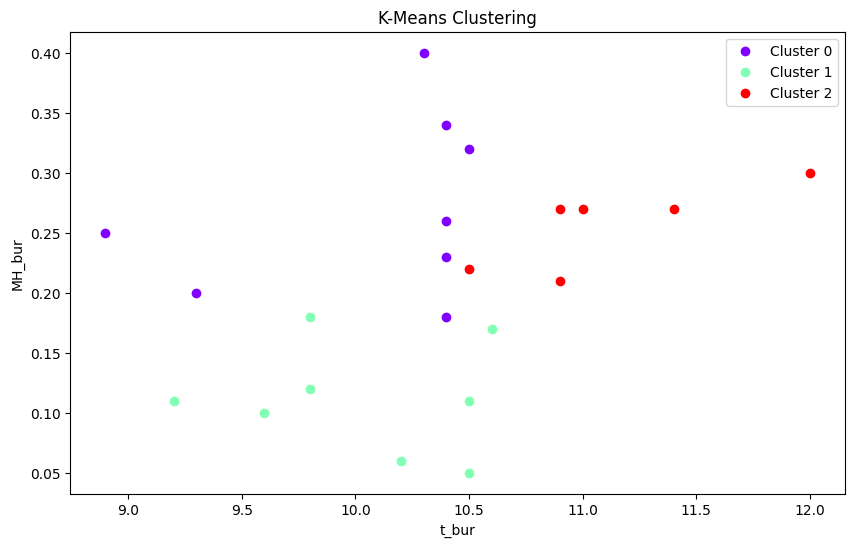

K-Means with 3 clusters:
{np.int32(0): np.int64(8), np.int32(1): np.int64(8), np.int32(2): np.int64(6)}


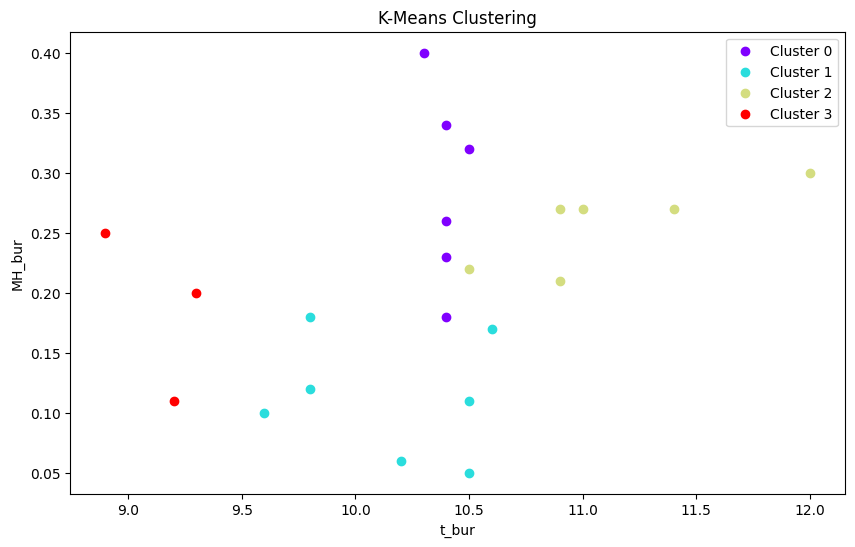

K-Means with 4 clusters:
{np.int32(0): np.int64(6), np.int32(1): np.int64(7), np.int32(2): np.int64(6), np.int32(3): np.int64(3)}

=== DBSCAN Clustering ===


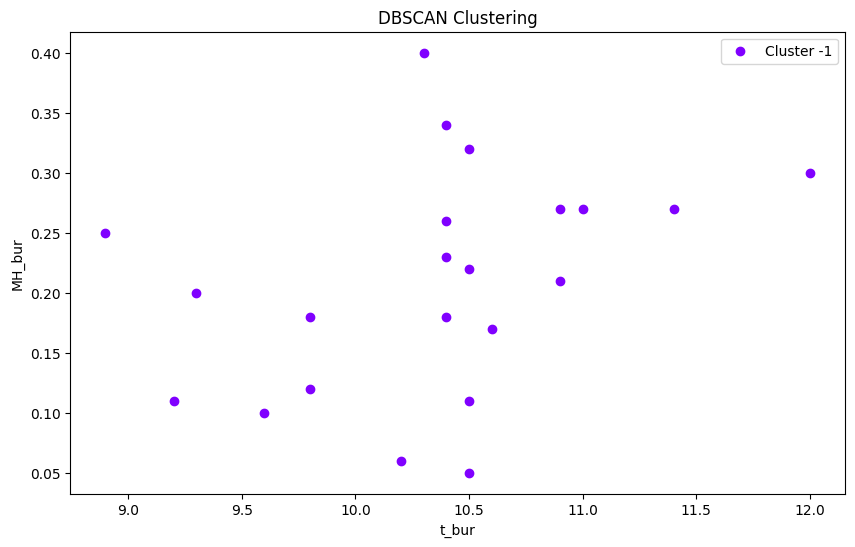


DBSCAN with eps=0.3:
{np.int64(-1): np.int64(22)}
Number of clusters: 0


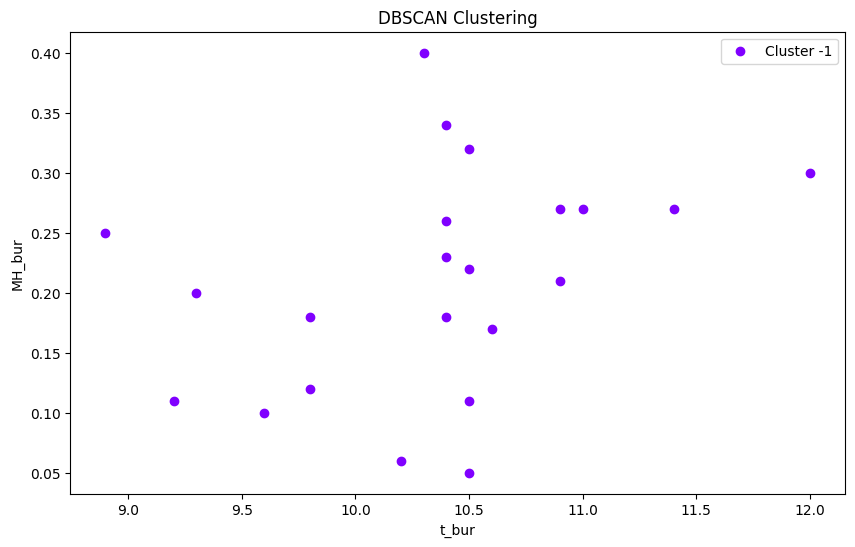


DBSCAN with eps=0.5:
{np.int64(-1): np.int64(22)}
Number of clusters: 0


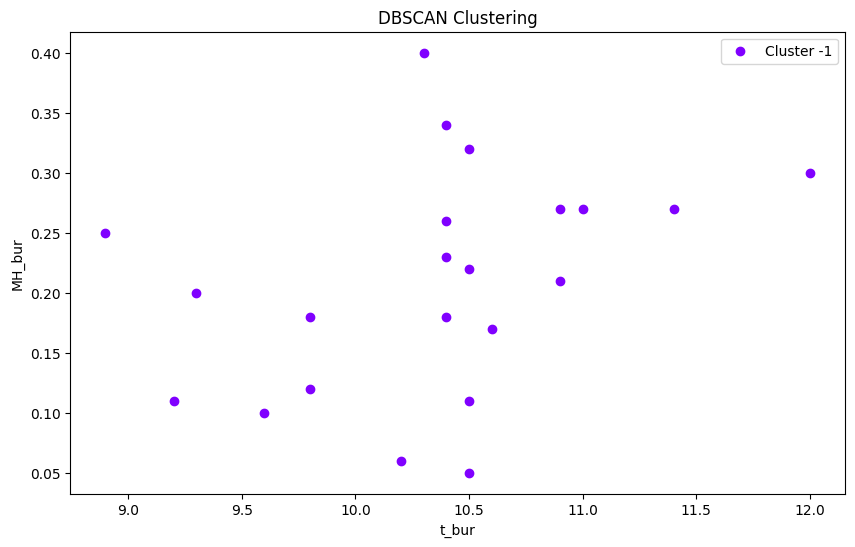


DBSCAN with eps=0.7:
{np.int64(-1): np.int64(22)}
Number of clusters: 0

=== Mean-Shift Clustering ===


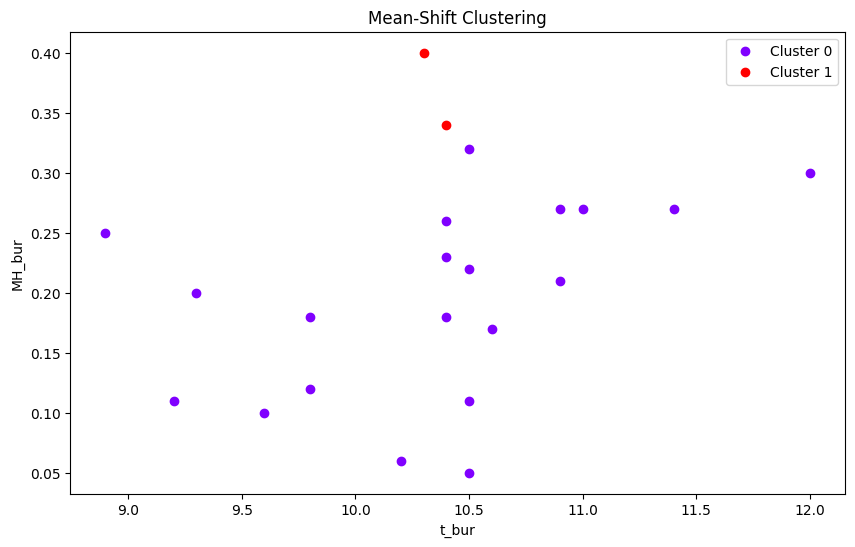

Mean-Shift clusters:
{np.int64(0): np.int64(20), np.int64(1): np.int64(2)}
Number of clusters found: 2

=== Gaussian Mixture Clustering ===


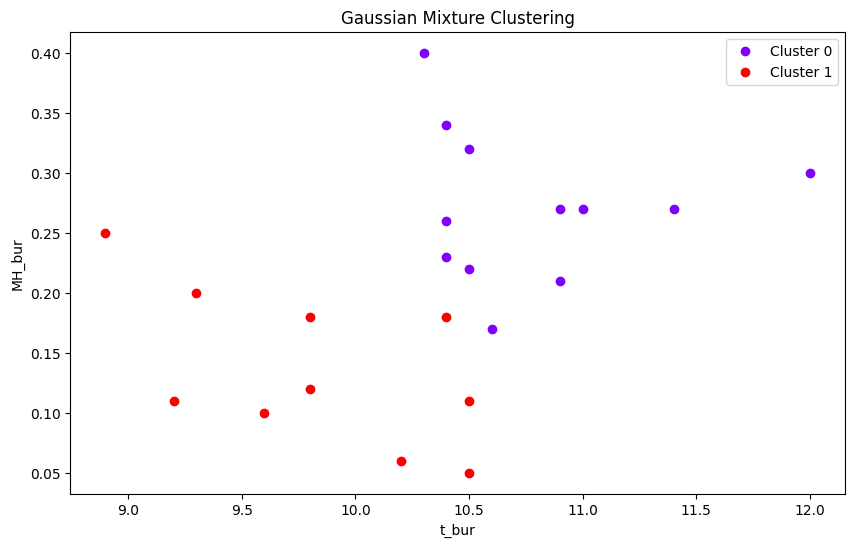


GMM with 2 components:
{np.int64(0): np.int64(12), np.int64(1): np.int64(10)}
BIC Score: 219.05862165613382


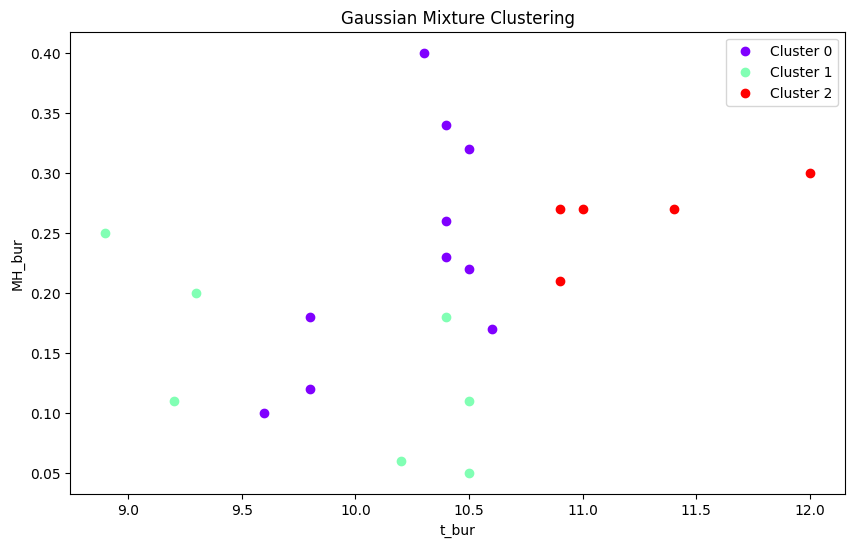


GMM with 3 components:
{np.int64(0): np.int64(10), np.int64(1): np.int64(7), np.int64(2): np.int64(5)}
BIC Score: 237.61077228732108


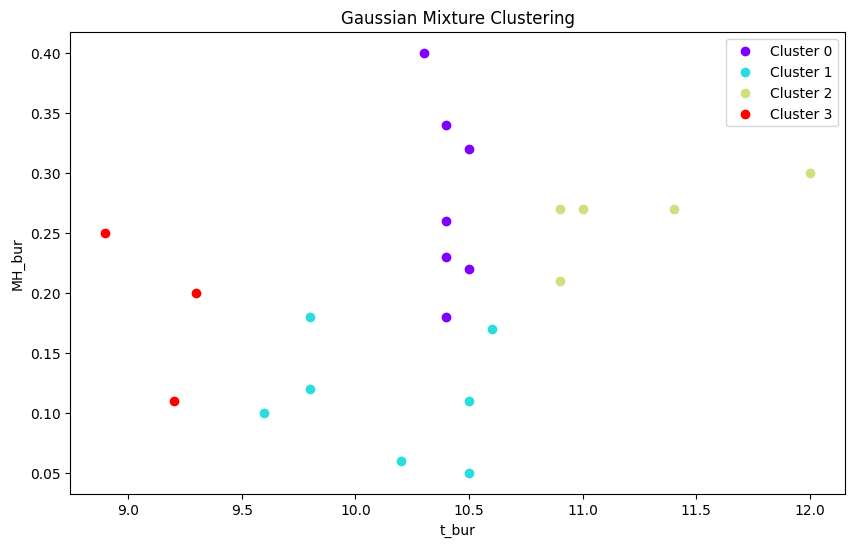


GMM with 4 components:
{np.int64(0): np.int64(7), np.int64(1): np.int64(7), np.int64(2): np.int64(5), np.int64(3): np.int64(3)}
BIC Score: 205.07083283357315

=== Hierarchical Clustering ===


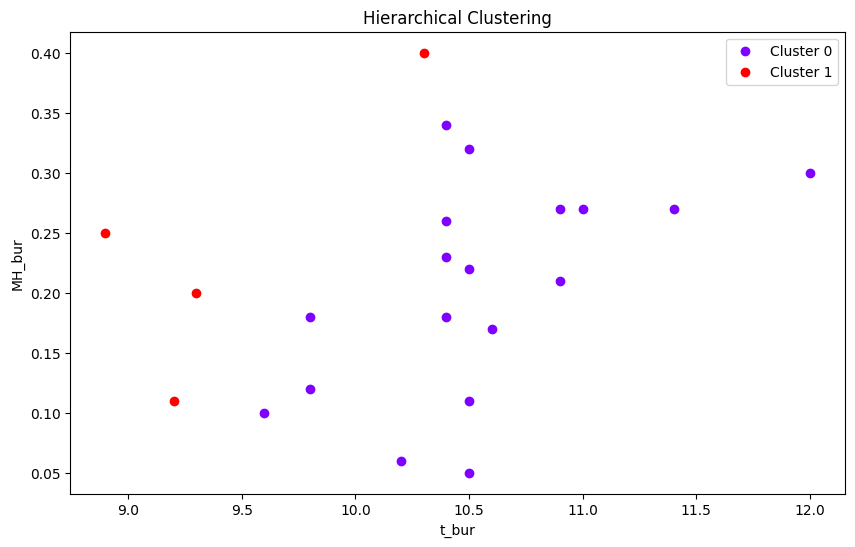


Hierarchical with 2 clusters:
{np.int64(0): np.int64(18), np.int64(1): np.int64(4)}


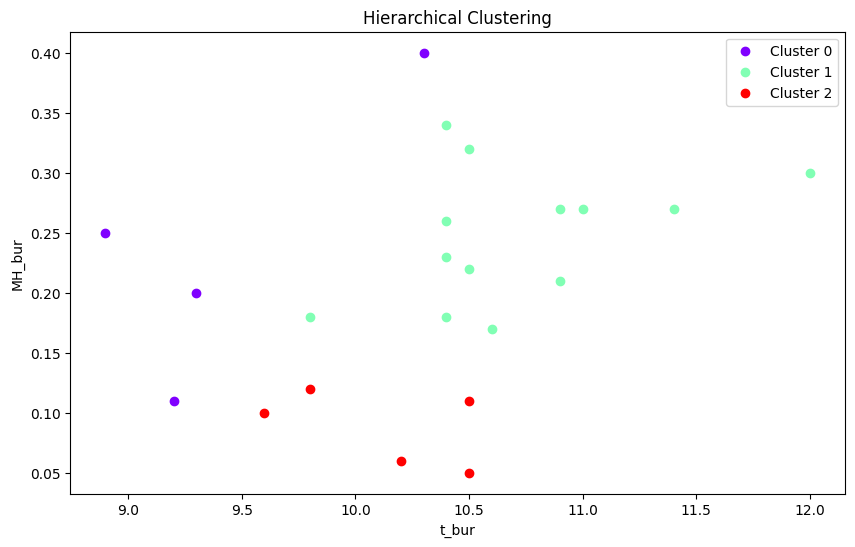


Hierarchical with 3 clusters:
{np.int64(0): np.int64(4), np.int64(1): np.int64(13), np.int64(2): np.int64(5)}


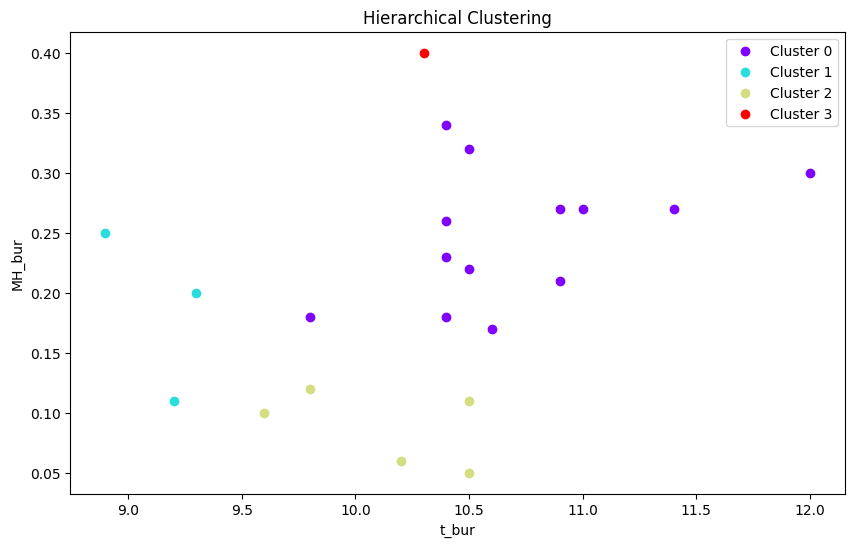


Hierarchical with 4 clusters:
{np.int64(0): np.int64(13), np.int64(1): np.int64(3), np.int64(2): np.int64(5), np.int64(3): np.int64(1)}

=== Comparison of All Methods ===


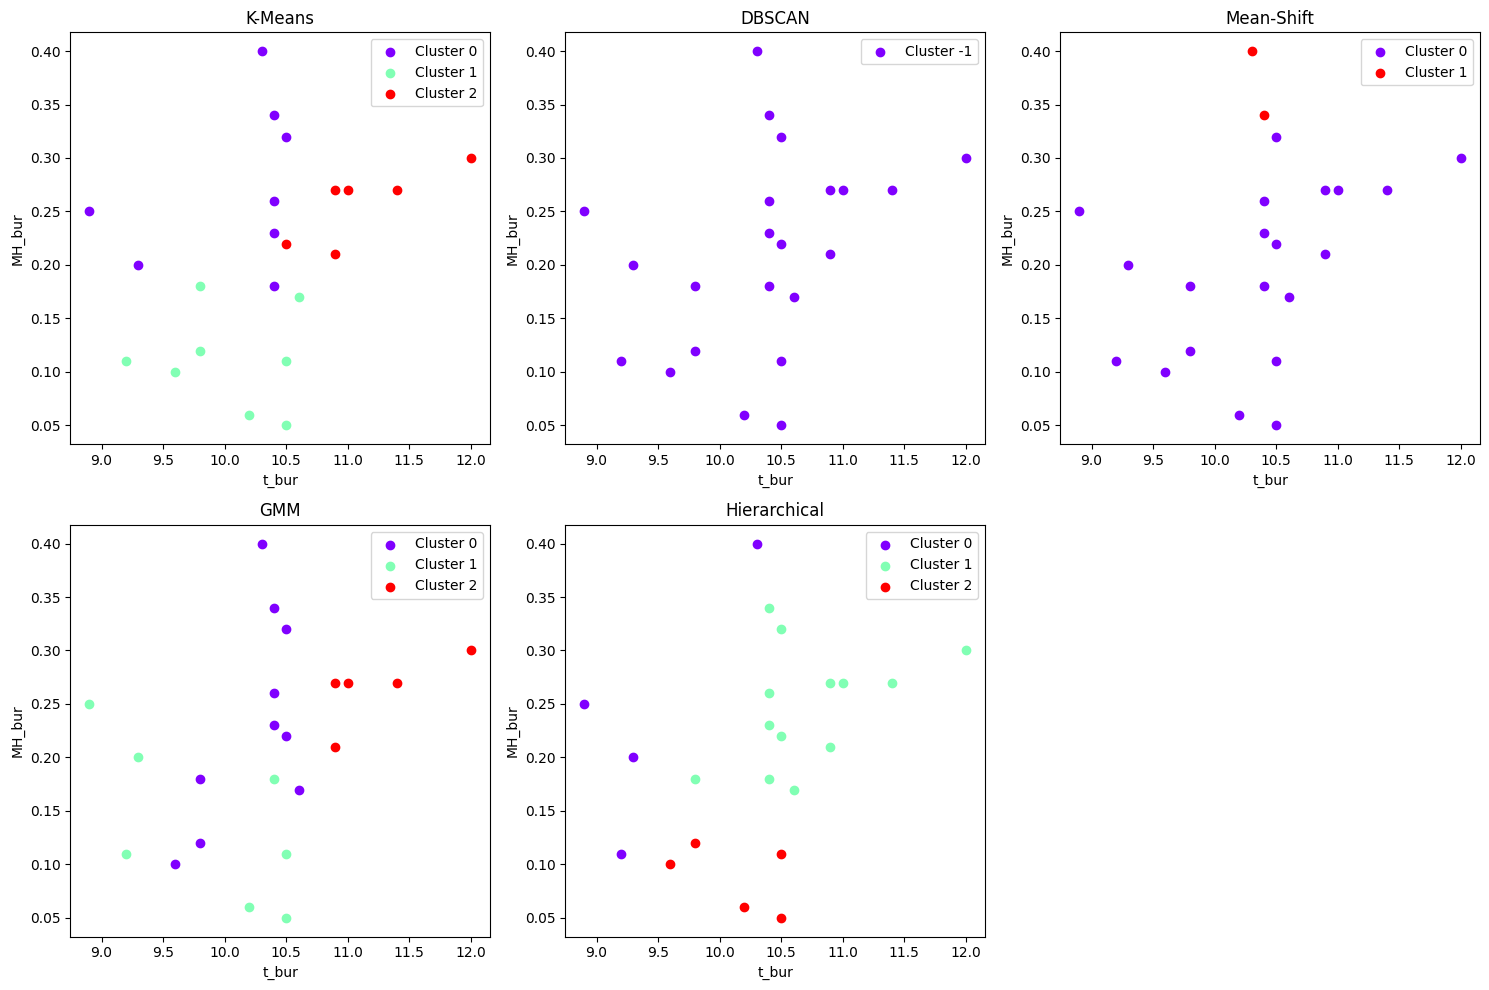


Summary of Results:

K-Means:
Number of clusters: 3
Cluster sizes: {0: np.int64(8), 1: np.int64(8), 2: np.int64(6)}

DBSCAN:
Number of clusters: 0
Cluster sizes: {}

Mean-Shift:
Number of clusters: 2
Cluster sizes: {0: np.int64(20), 1: np.int64(2)}

GMM:
Number of clusters: 3
Cluster sizes: {0: np.int64(10), 1: np.int64(7), 2: np.int64(5)}

Hierarchical:
Number of clusters: 3
Cluster sizes: {0: np.int64(4), 1: np.int64(13), 2: np.int64(5)}


In [14]:
####################### BLOCK 7: USAGE EXAMPLES #######################

# Print available features in your dataset
print("Available features:", df.columns.tolist())

# Select features for clustering
# Example using column names
selected_features = ['t_bur', 'MH_bur', 'Mg_Fe']
# OR using column indices
# selected_features = [0, 1, 2]

# 1. K-Means Example
print("\n=== K-Means Clustering ===")
# Try different numbers of clusters
for n_clusters in [2, 3, 4]:
    kmeans_model, kmeans_labels = kmeans_clustering(df, selected_features, n_clusters=n_clusters)
    # Count samples in each cluster
    unique, counts = np.unique(kmeans_labels, return_counts=True)
    print(f"K-Means with {n_clusters} clusters:")
    print(dict(zip(unique, counts)))

# 2. DBSCAN Example
print("\n=== DBSCAN Clustering ===")
# Try different eps values
for eps in [0.3, 0.5, 0.7]:
    dbscan_model, dbscan_labels = dbscan_clustering(df, selected_features, 
                                                  eps=eps, 
                                                  min_samples=5)
    # Count samples in each cluster (-1 is noise)
    unique, counts = np.unique(dbscan_labels, return_counts=True)
    print(f"\nDBSCAN with eps={eps}:")
    print(dict(zip(unique, counts)))
    print(f"Number of clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

# 3. Mean-Shift Example
print("\n=== Mean-Shift Clustering ===")
ms_model, ms_labels = meanshift_clustering(df, selected_features)
# Count samples in each cluster
unique, counts = np.unique(ms_labels, return_counts=True)
print("Mean-Shift clusters:")
print(dict(zip(unique, counts)))
print(f"Number of clusters found: {len(unique)}")

# 4. Gaussian Mixture Example
print("\n=== Gaussian Mixture Clustering ===")
# Try different numbers of components
for n_components in [2, 3, 4]:
    gmm_model, gmm_labels = gmm_clustering(df, selected_features, 
                                         n_components=n_components)
    # Count samples in each cluster
    unique, counts = np.unique(gmm_labels, return_counts=True)
    print(f"\nGMM with {n_components} components:")
    print(dict(zip(unique, counts)))
    
    # Calculate BIC score correctly
    X, _ = prepare_data(df, selected_features)
    X_scaled = StandardScaler().fit_transform(X)
    print(f"BIC Score: {gmm_model.bic(X_scaled)}")

# 5. Hierarchical Clustering Example
print("\n=== Hierarchical Clustering ===")
# Try different numbers of clusters
for n_clusters in [2, 3, 4]:
    hc_model, hc_labels = hierarchical_clustering(df, selected_features, 
                                                n_clusters=n_clusters)
    # Count samples in each cluster
    unique, counts = np.unique(hc_labels, return_counts=True)
    print(f"\nHierarchical with {n_clusters} clusters:")
    print(dict(zip(unique, counts)))

# Compare all methods (using default parameters)
print("\n=== Comparison of All Methods ===")
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Prepare data once
X, feature_names = prepare_data(df, selected_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
plot_clusters(X, kmeans_labels, feature_names, "K-Means", axes[0])

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
plot_clusters(X, dbscan_labels, feature_names, "DBSCAN", axes[1])

# Mean-Shift
ms = MeanShift(bandwidth=2)
ms_labels = ms.fit_predict(X_scaled)
plot_clusters(X, ms_labels, feature_names, "Mean-Shift", axes[2])

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
plot_clusters(X, gmm_labels, feature_names, "GMM", axes[3])

# Hierarchical
hc = AgglomerativeClustering(n_clusters=3)
hc_labels = hc.fit_predict(X_scaled)
plot_clusters(X, hc_labels, feature_names, "Hierarchical", axes[4])

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Results:")
methods = {
    "K-Means": kmeans_labels,
    "DBSCAN": dbscan_labels,
    "Mean-Shift": ms_labels,
    "GMM": gmm_labels,
    "Hierarchical": hc_labels
}

for method_name, labels in methods.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"\n{method_name}:")
    print(f"Number of clusters: {n_clusters}")
    print("Cluster sizes:", dict(zip(range(n_clusters), 
          np.bincount(labels[labels >= 0]))))